In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import os

# Force CPU for feature extraction to reduce GPU memory load
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load and preprocess MNIST (limit to 2000 samples)
(x_train, y_train), _ = mnist.load_data()
x_train = x_train[:2000]
y_train = y_train[:2000]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train = np.expand_dims(x_train, -1)
x_train = tf.image.resize(x_train, [96, 96])
x_train = tf.image.grayscale_to_rgb(x_train)
x_train = preprocess_input(tf.cast(x_train, tf.float32))

In [ ]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(96, 96, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


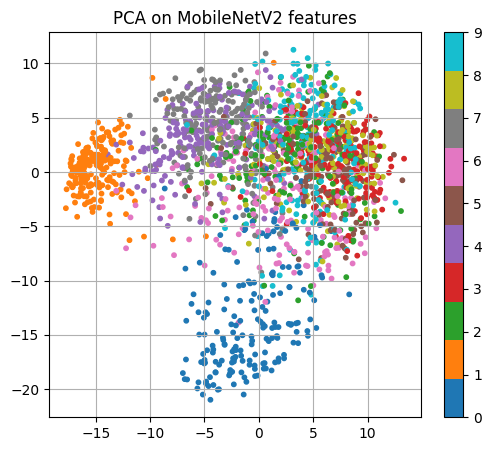

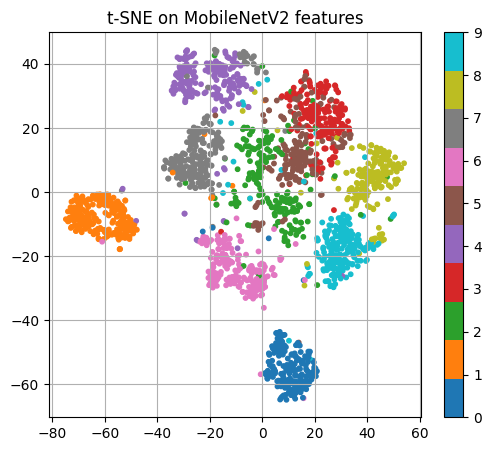

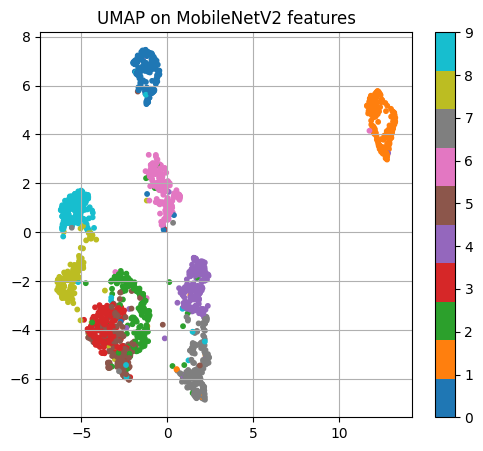

In [ ]:
features = []
batch_size = 32

for i in range(0, len(x_train), batch_size):
    batch = x_train[i:i+batch_size]
    feats = mobilenet(batch, training=False)
    features.append(feats.numpy())

features = np.concatenate(features, axis=0)

# Dimensionality reduction
pca = PCA(n_components=2).fit_transform(features)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca").fit_transform(features)
umap_2d = umap.UMAP(n_components=2).fit_transform(features)

# Plot function
def plot_embedding(X, y, title):
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=10)
    plt.title(title)
    plt.colorbar(scatter, ticks=range(10))
    plt.grid(True)

plot_embedding(pca, y_train, "PCA on MobileNetV2 features")
plot_embedding(tsne, y_train, "t-SNE on MobileNetV2 features")
plot_embedding(umap_2d, y_train, "UMAP on MobileNetV2 features")
plt.show()

In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# -------------------------
# STEP 1: Load and Preprocess MNIST in Batches
# -------------------------
(x_train, y_train), _ = mnist.load_data()
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)

# Use only a subset to make it faster
x_train, y_train = x_train[:2000], y_train[:2000]

In [ ]:
# Parameters
batch_size = 250
target_size = (96, 96)
num_samples = x_train.shape[0]
processed_batches = []

for i in range(0, num_samples, batch_size):
    batch = x_train[i:i+batch_size]
    resized = tf.image.resize(batch, target_size)
    rgb = tf.image.grayscale_to_rgb(resized)
    normalized = rgb / 255.0
    processed_batches.append(normalized)

x_train_processed = tf.concat(processed_batches, axis=0)
y_train_categorical = to_categorical(y_train, num_classes=10)

In [ ]:
# -------------------------
# STEP 2: Load Pretrained CNN and Fine-tune
# -------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Freeze base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_processed, y_train_categorical, epochs=5, batch_size=32, verbose=2)


Epoch 1/5
63/63 - 18s - 281ms/step - accuracy: 0.7175 - loss: 0.8896
Epoch 2/5
63/63 - 9s - 147ms/step - accuracy: 0.9055 - loss: 0.3024
Epoch 3/5
63/63 - 11s - 167ms/step - accuracy: 0.9390 - loss: 0.2058
Epoch 4/5
63/63 - 11s - 173ms/step - accuracy: 0.9495 - loss: 0.1602
Epoch 5/5
63/63 - 10s - 163ms/step - accuracy: 0.9615 - loss: 0.1311


In [ ]:
# -------------------------
# STEP 3: Extract Features After Fine-tuning
# -------------------------
features = base_model.predict(x_train_processed)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


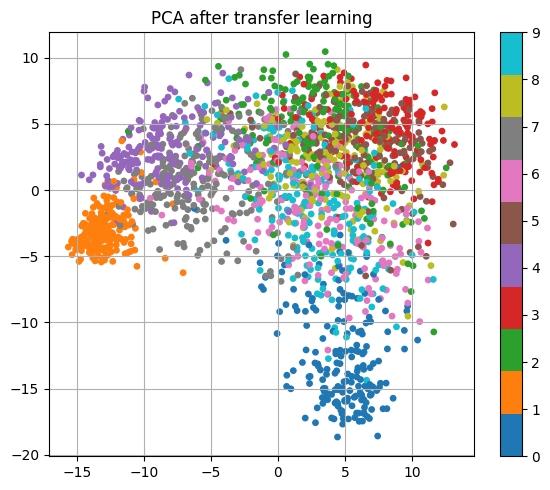

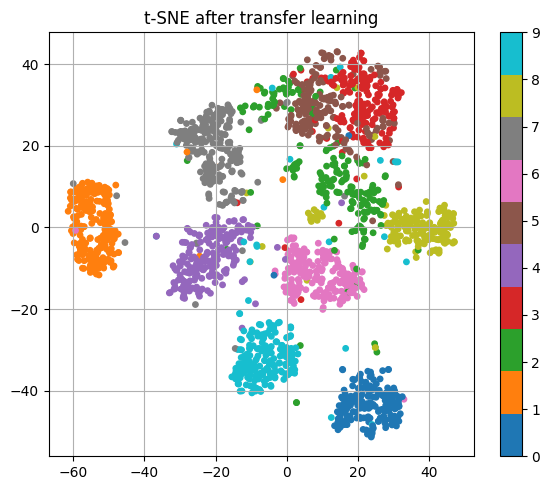

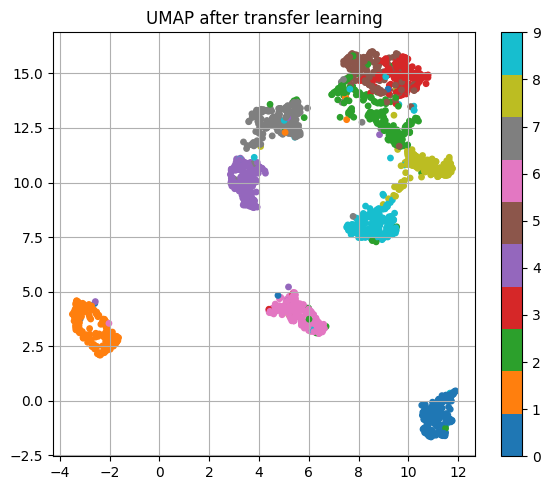

In [ ]:
def plot_dim_reduction(X, y, title):
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=15)
    plt.title(title)
    plt.colorbar(scatter, ticks=range(10))  # Add colorbar with ticks for classes
    plt.grid(True)
    plt.tight_layout()

# PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
plot_dim_reduction(features_pca, y_train, "PCA after transfer learning")

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features)
plot_dim_reduction(features_tsne, y_train, "t-SNE after transfer learning")

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
features_umap = reducer.fit_transform(features)
plot_dim_reduction(features_umap, y_train, "UMAP after transfer learning")

plt.show()
